In [1]:
import numpy as np
from scipy.special import hyp1f1
from sympy import hyper
from scipy import integrate
from scipy.special import gamma
import matplotlib.pyplot as plt
import time as tm
from math import factorial
from numpy.linalg import eigh

from __future__ import division

%matplotlib inline

# Defino funcion de Bessel

In [2]:
def Bessel(k,l,r):
    rho = k*float(r)
    
    if rho == 0.0:
        jl = 0
        if l == 0:
            jl = 1
        return jl
    
    j0 = np.sin(rho) / rho
    j1 = np.sin(rho) / rho**2 - np.cos(rho) / rho
    
    if l == 0:
        return j0
    
    if l == 1:
        return j1
    
    for j in range(1,l):
        jl = (2*l-1)/rho * j1 - j0
        j1 = jl
        j0 = j1
        
    return jl

# Defino funcion de Neumann

In [3]:
def Neumann(k,l,r):
    rho = k*r
    n0 = -np.cos(rho) / rho
    n1 = -np.cos(rho) / rho**2 - np.sin(rho) / rho
    
    if l == 0:
        return n0
    
    if l == 1:
        return n1
    
    for j in range(1,l):
        nl = (2*l-1)/rho*n1 - n0
        n1 = nl
        n0 = n1
        
    return nl

# Defino las funciones de onda continuas

In [48]:
import sympy as sp
from sympy import oo
from sympy import gamma
from sympy import Rational
from __future__ import division

In [49]:
sp.init_printing()
r = sp.Symbol('r', positive=True, real=True)
k = sp.Symbol('k', positive=True, real=True)
l = sp.Symbol('l', positive=True, integer=True)
n = sp.Symbol('n', positive=True, integer=True)
z = sp.Symbol('z', positive=True, integer=True)

In [50]:
def Rkl(k,l,z,r):
    rnorm = k*sp.sqrt(2/sp.pi)*sp.exp(z/k*sp.pi/2)*sp.Abs(gamma(1+l-sp.I*z/k))/sp.factorial(2*l+1)
    hyp = hyper((-sp.I*z/k+l+1,), (2*l+2,), -2*sp.I*k*r)
    rfunc = (2*k*r)**l * sp.exp(sp.I*k*r) * hyp
    R = rnorm * rfunc
    return R

In [51]:
def Rkl_io(k,l,z,io,r):
    return Rkl(k,l,z,r)*(sp.I)**(-io*l)*sp.exp(io*1j*sp.arg(gamma(1+l-sp.I*z/k)))

# Chequeo la ec de Schrodinger

In [8]:
-1/2*sp.diff((r*Rkl(k,l,z,r)),r,2)+(-z/r+l*(l+1)/(2*r**2)-k**2/2)*(r*Rkl(k,l,z,r))

                                                                              
                                                                              
                                                                              
           _______________________________          ⎛   2                ⎞    
          ╱  ⎛        ⅈ⋅z⎞  ⎛        ⅈ⋅z⎞         l ⎜  k    l⋅(l + 1)   z⎟  ⅈ⋅
√2⋅k⋅r⋅  ╱  Γ⎜l + 1 - ───⎟⋅Γ⎜l + 1 + ───⎟ ⋅(2⋅k⋅r) ⋅⎜- ── + ───────── - ─⎟⋅ℯ  
       ╲╱    ⎝         k ⎠  ⎝         k ⎠           ⎜  2          2     r⎟    
                                                    ⎝          2⋅r       ⎠    
──────────────────────────────────────────────────────────────────────────────
                                                   √π⋅(2⋅l + 1)!              

                                                                              
                                                                              
     π⋅z                                           

- Como no me dio cero, voy a chequear ambos lados de la ec de Schrodinger a ver que se anula efectivamente

In [9]:
LHS = -0.5*sp.diff((r*Rkl(k,l,z,r)),r,2)+(-z/r+l*(l+1)/(2*r**2))*(r*Rkl(k,l,z,r))
RHS = k**2/2*(r*Rkl(k,l,z,r))

In [10]:
k0 = 2
l0 = 0
z0 = 4
nsize = 200
rs = np.linspace(0.01,20,nsize)

In [11]:
LHS_eval_real = np.zeros(nsize)
RHS_eval_real = np.zeros(nsize)
LHS_eval_imag = np.zeros(nsize)
RHS_eval_imag = np.zeros(nsize)

for i,r0 in enumerate(rs):
    LHS_eval = np.array(LHS.evalf(subs={k:k0,l:l0,z:z0,r:r0})).astype(np.complex128)
    RHS_eval = np.array(RHS.evalf(subs={k:k0,l:l0,z:z0,r:r0})).astype(np.complex128)
    
    LHS_eval_real[i] = LHS_eval.real
    RHS_eval_real[i] = RHS_eval.real
    LHS_eval_imag[i] = LHS_eval.imag
    RHS_eval_imag[i] = RHS_eval.imag
    if i%(nsize/10) == 0: print i
print "OK!"

0
20
40
60
80
100
120
140
160
180
OK!


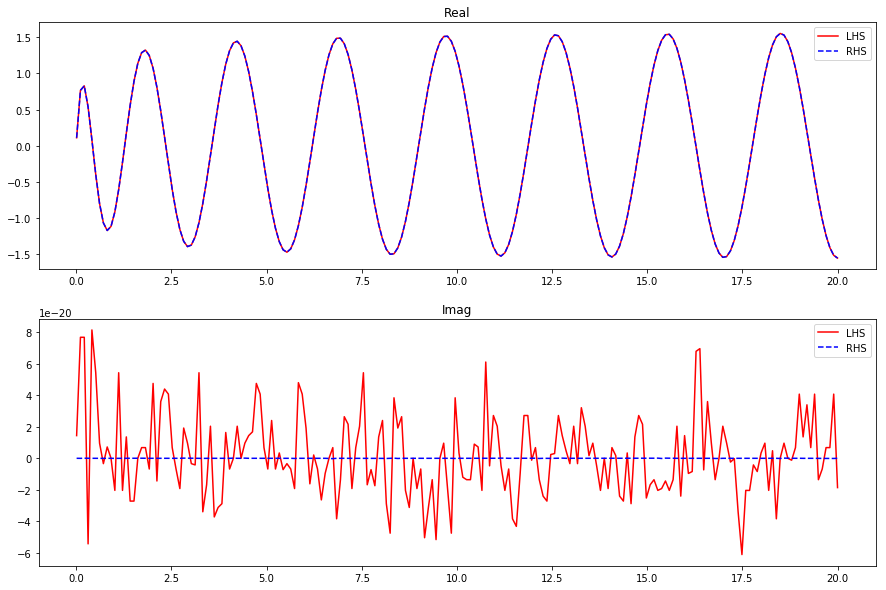

In [12]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,10))
ax1.plot(rs, LHS_eval_real, 'r-', label='LHS')
ax1.plot(rs, RHS_eval_real, 'b--', label='RHS')
ax1.set_title("Real")
ax1.legend(loc='best')

ax2.plot(rs, LHS_eval_imag, 'r-', label='LHS')
ax2.plot(rs, RHS_eval_imag, 'b--', label='RHS')
ax2.set_title("Imag")
ax2.legend(loc='best')

# Chequeo 3 k's cercanos

In [13]:
nsize = 1000
xmax = 50
xmin = 0.
x = np.linspace(xmin,xmax,nsize)
psi_1 = np.zeros(nsize, dtype=complex)
psi_2 = np.zeros(nsize, dtype=complex)
psi_3 = np.zeros(nsize, dtype=complex)
klist = [0.5,0.6,0.7]

In [14]:
for i in range(nsize):
    psi_1[i] = Rkl(klist[0],0,1,x[i]).evalf()
    psi_2[i] = Rkl(klist[1],0,1,x[i]).evalf()
    psi_3[i] = Rkl(klist[2],0,1,x[i]).evalf()

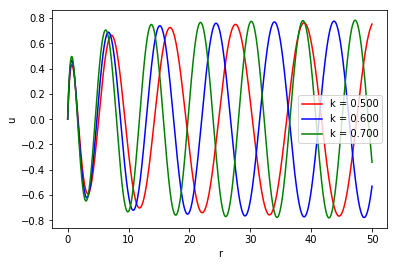

In [15]:
plt.plot(x,x*psi_1.real,'r',label='k = {:.3f}'.format(klist[0]))
plt.plot(x,x*psi_2.real,'b',label='k = {:.3f}'.format(klist[1]))
plt.plot(x,x*psi_3.real,'g',label='k = {:.3f}'.format(klist[2]))
plt.xlabel('r')
plt.ylabel('u')
plt.legend(loc='best')
plt.show()

- Si bien en el origen las funciones salen igual, se puede observar el desfasaje a medida que el $r$ incrementa

# Kato

In [52]:
sp.N(sp.diff(Rkl(k,l,z,r),r)/Rkl(k,l,z,r),subs={k:100,l:0,z:10,r:0})

- Se chequea la condicion de Kato

# Solucion Numerica
### Diferencias finitas

In [32]:
# usando numpy
def H_matriz(ri,rf,N,Z,l):
    r = np.linspace(ri,rf,N)
    h = (rf-ri)/float(N)
    
    offDiag_der2 = np.ones(len(r)-1)
    diag_cent = l*(l+1)/r**2
    T_matriz = (np.diag(offDiag_der2,-1) - 2*np.eye(N,dtype=float) + np.diag(offDiag_der2,1))/(-2*h**2) \
                + np.diag(diag_cent)
    
    diag_V = -Z/r
    V_matriz = np.diag(diag_V)
    
    return T_matriz+V_matriz, r

In [33]:
Z0 = 4
rmin = 0.001
rmax = 3
npuntos = 2000
l0 = 0
H, r = H_matriz(rmin,rmax,npuntos,Z0,l0)

In [34]:
# E son las energias, v las respectivas funciones de onda 
# sin normalizar como columnas de una matriz v de autovectores
E, v = eigh(H)
E[:10]

array([-8.05744342, -1.94984354,  0.30697469,  3.68337343,  8.28858386,
       14.06269447, 20.97805416, 29.02026216, 38.18095239, 48.45483385])

In [35]:
i = 2
k0 = np.sqrt(E[i]*2)
k0

In [36]:
sign = 1
psi_calc = v[:,i]*sign
psi_calc = psi_calc/np.sqrt(np.trapz(r**2*psi_calc**2,r))

In [37]:
psi = np.zeros(npuntos,dtype=complex)
for j in range(npuntos):
    psi[j] = r[j]*Rkl(k0,0,4,r[j]).evalf()

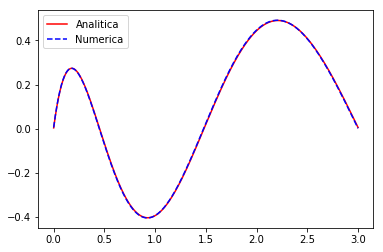

In [38]:
# Renormalizo cada funcion a la unidad en el intervalo elegido
plt.plot(r,psi.real/sp.sqrt(np.trapz((r*psi.real)**2,r)),'r',label='Analitica')
plt.plot(r,psi_calc,'b--',label='Numerica')
plt.legend(loc='best')

- La funcion numerica concuerda con la analitica

## Chequeo para Z = 0 si da Bessel

In [39]:
xmax = 20
xmin = 0
nsize = 500
x = np.linspace(xmin,xmax,nsize)
psi = np.zeros(nsize,dtype = complex)
jbes = np.zeros(nsize)

In [45]:
k = 1.5
lq = 1
for i in range(nsize):
    psi[i] = Rkl(k,lq,0,x[i])
    jbes[i] = Bessel(k,lq,x[i])

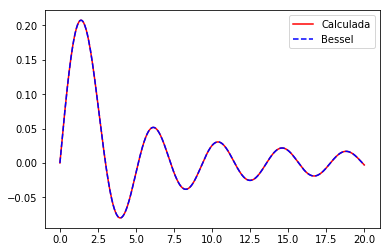

In [46]:
# Renormalizo cada funcion a la unidad en el intervalo elegido
plt.plot(x,psi.real/sp.sqrt(np.trapz(psi.real**2*x**2,x)),'r',label='Calculada')
plt.plot(x,jbes/np.sqrt(np.trapz(jbes**2*x**2,x)),'b--',label='Bessel')
plt.legend(loc='best')

- Se puede ver como punto a punto la solucion numerica concuerda con Bessel cuando no hay potencial Coulombiano